# Unsupervised Monocular Depth Estimation with Left-Right Consistency

![Image of Yaktocat](https://user-images.githubusercontent.com/20357655/144081326-a5eefc0e-3492-44d6-b7c6-95e4cf5df348.png)

In this homework we will try to train a neural network for `depth estimation` from an image without explicit annotation (a disparity map or something else) as opposed to `DispNet` from the seminar.

Method exploit epipolar geometry to generate disparity images by training our network with an image reconstruction loss. Training loss enforces consistency between the disparities produced relative to both the left and right images, leading to improved performance and robustness compared to existing approaches.

https://arxiv.org/pdf/1609.03677.pdf

# Data

Our training data consisted of stereo pairs from the `KITTI` dataset. We will take some of the data from the seminar, and the rest we will download additionally

In [1]:
# ! wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework04/gfile.py
# import gfile

In [2]:
# import gfile
# gfile.download_list(
#     'https://drive.google.com/file/d/12zitJCsOVmoCHII5Ym_t2AAORXb6WMyU',
#     filename='kitti_stereo_2012_training_data.zip',
#     target_dir='.'
# )

In [3]:
# !unzip -q ./kitti_stereo_2012_training_data.zip

The directories `kitti_stereo_2012_training_data/train/colored_0` and `kitti_stereo_2012_training_data/train/colored_1` contain left and right images respectively

## Download additional data

In [4]:
# !mkdir kitti_stereo_2015
# !wget -O kitti_stereo_2015/part_1.zip \
#     https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0032/2011_09_26_drive_0032_sync.zip

In [5]:
# !unzip kitti_stereo_2015/part_1.zip -d kitti_stereo_2015

The directories `kitti_stereo_2015/2011_09_26/2011_09_26_drive_0032_sync/image_02/data/*.png` and `kitti_stereo_2015/2011_09_26/2011_09_26_drive_0032_sync/image_03/data/*.png` contain left and right images respectively.

So, let's copy images in first dataset

In [6]:
# !cp kitti_stereo_2015/2011_09_26/2011_09_26_drive_0032_sync/image_02/data/*.png \
#     kitti_stereo_2012_training_data/train/colored_0/

# !cp kitti_stereo_2015/2011_09_26/2011_09_26_drive_0032_sync/image_03/data/*.png \
#     kitti_stereo_2012_training_data/train/colored_1/

---

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
from typing import Optional, Union, Tuple, List

import time
import random
from pathlib import Path
from tqdm import tqdm
from IPython import display
from functools import partial
from dataclasses import dataclass, asdict

In [9]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image

In [10]:
from PIL import Image
import skimage
import skimage.io

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
class KITTIStereoRAM(Dataset):
    def __init__(self, root, train=True, transforms=None):
        super(KITTIStereoRAM, self).__init__()

        self.root = Path(root)
        if train:
            self.path_to_dataset = self.root / 'train'
        else:
            self.path_to_dataset = self.root / 'val'

        self.transforms = transforms
        self.left_images = []
        self.right_images = []
        for left_image_path in tqdm((self.path_to_dataset / 'colored_0').rglob('*.png')):
            right_image_path = left_image_path.as_posix().replace('colored_0', 'colored_1')
            left_image_path = left_image_path.as_posix()

            left_image = read_image(left_image_path)
            right_image = read_image(right_image_path)

            self.left_images.append(left_image)
            self.right_images.append(right_image)

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, index):
        left_img = self.left_images[index]
        right_img = self.right_images[index]

        if self.transforms is not None:
            left_img, right_img = self.transforms(left_img, right_img)
        return left_img, right_img

## Example of data

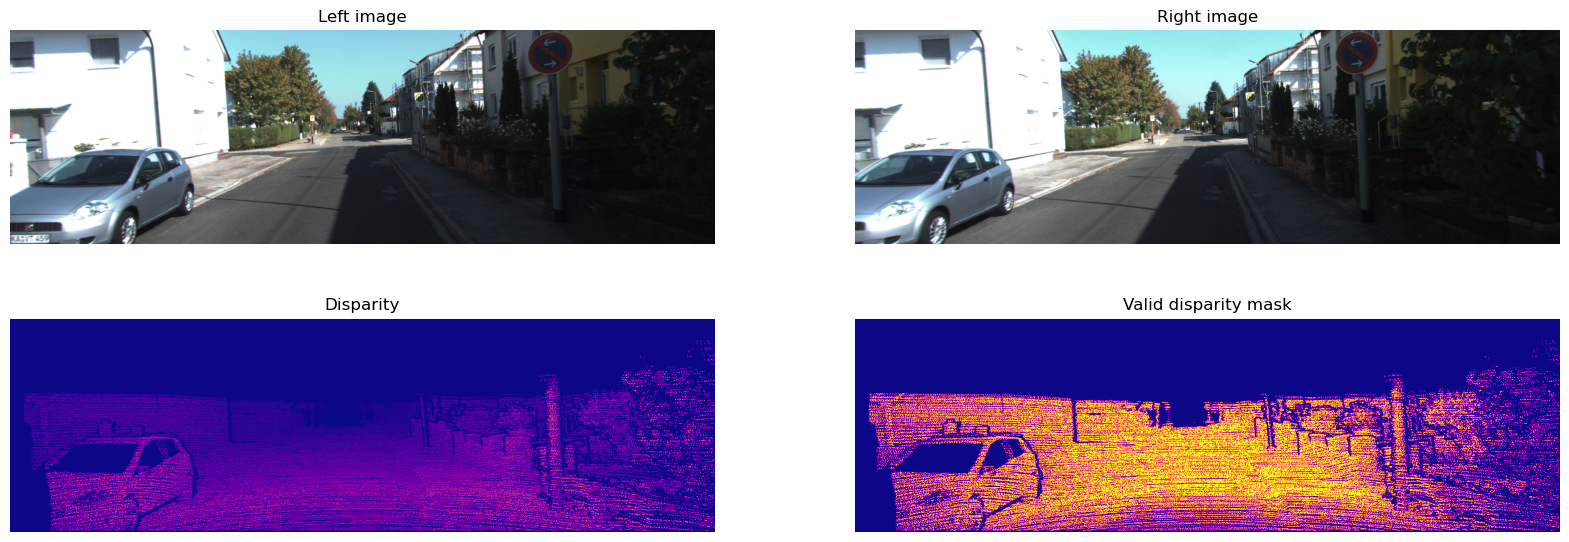

In [13]:
img_name = "000002_10.png"

plt.figure(figsize=(20, 7), dpi=100)

plt.subplot(2, 2, 1)
plt.title('Left image')
plt.imshow(Image.open(
    f'./kitti_stereo_2012_training_data/train/colored_0/{img_name}'))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Right image')
plt.imshow(Image.open(
    f'./kitti_stereo_2012_training_data/train/colored_1/{img_name}'))
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Disparity')
disp = np.array(Image.open(
    f'./kitti_stereo_2012_training_data/train/disp_noc/{img_name}'))
plt.imshow(disp / 255, "plasma")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Valid disparity mask')
plt.imshow(disp > 0, "plasma")
plt.axis('off')
plt.show()

In [14]:
def pad_to_size(images, min_height, min_width):
    if images.shape[1] < min_height:
        images = torchvision.transforms.functional.pad(
            images, (0, 0, 0, min_height-images.shape[1]),
        )
    if images.shape[2] < min_width:
        images = torchvision.transforms.functional.pad(
            images, (0, 0, min_width - images.shape[2], 0),
        )
    return images


def normalize(image):
    # torch.uint8 -> torch.float32, [0; 1]
    return image / 255.


color_jitter = torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2)

# min kitti shape is [370, 1226], max shape is [376, 1242]
PAD_HEIGHT = 128 * 3
PAD_WIDTH = 1280

RESIZES_HEIGHT = PAD_HEIGHT
RESIZES_WIDTH = PAD_WIDTH


def transforms_train(left_image, right_image):
    left_image = color_jitter(left_image)
    right_image = color_jitter(right_image)
    if random.random() < 0.5:
        left_image = torchvision.transforms.functional.hflip(left_image)
        right_image = torchvision.transforms.functional.hflip(right_image)

    left_image = pad_to_size(left_image, PAD_HEIGHT, PAD_WIDTH)
    right_image = pad_to_size(right_image, PAD_HEIGHT, PAD_WIDTH)

    left_image = torchvision.transforms.functional.resize(
        left_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    right_image = torchvision.transforms.functional.resize(
        right_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    return normalize(left_image), normalize(right_image)


def transforms_test(left_image, right_image):
    left_image = pad_to_size(left_image, PAD_HEIGHT, PAD_WIDTH)
    right_image = pad_to_size(right_image, PAD_HEIGHT, PAD_WIDTH)

    left_image = torchvision.transforms.functional.resize(
        left_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    right_image = torchvision.transforms.functional.resize(
        right_image, (RESIZES_HEIGHT, RESIZES_WIDTH)
    )
    return normalize(left_image), normalize(right_image)

In [15]:
train_dataset = KITTIStereoRAM(
    root="./kitti_stereo_2012_training_data/",
    train=True, transforms=transforms_train
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, pin_memory=True,
)

validation_dataset = KITTIStereoRAM(
    root="./kitti_stereo_2012_training_data/",
    train=False, transforms=transforms_test
)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=1, shuffle=False,
)

545it [00:10, 54.28it/s]
39it [00:00, 46.55it/s]


# Model

Encoder-decoder architecture with VGGnet backbone, but without BatchNormalization and MaxPooling.
Actually architecture is inspired by DispNet from seminar.

![Model](https://user-images.githubusercontent.com/20357655/144081892-91bf13fb-8143-44d2-844b-8f03b207f9fc.png)

## Encoder

Let's implement base `ConvBlock` and `EncoderBlock`:

In [16]:
class ConvBlock(nn.Sequential):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        activation: nn.Module = nn.ReLU,
        normalization: bool = True,
        padding: Optional[int] = None,
    ):
        if padding is None:
            padding = (kernel_size - 1) // 2

        layers = [
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding,
                bias=not normalization
            ),
        ]
        if normalization:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(activation())
        super().__init__(*layers)


class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self._in_channels = in_channels
        self._out_channels = out_channels
        self._kernel_size = kernel_size

        self.convs = nn.Sequential(
            ConvBlock(
                self._in_channels, self._out_channels, self._kernel_size,
                stride=2, activation=partial(nn.ELU, inplace=True)
            ),
            ConvBlock(
                self._out_channels, self._out_channels, self._kernel_size,
                stride=1, activation=partial(nn.ELU, inplace=True)
            )
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.convs(input)

## Decode Block

It looks like below:

![image](https://user-images.githubusercontent.com/20357655/144682874-38496b10-e5a3-4455-af9d-2cdc375a1ae5.png)

More precisely, first three block consist of:
   1. Up-Convolution (Upsample + Conv)
   2. Concat current feature map (from 1) with skip-connection from encoder
   3. Convolution
    
Last four block are complement by `DisparityHead` and we predict disparity maps. So, in addition to the previous computations, we additionally predict two disparity maps (for left and right image). And these maps will later be used to calculate the loss functions.

In [17]:
class DisparityHead(nn.Module):

    def __init__(self, in_channels: int, disparity_max: float):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels=2,
                              kernel_size=3, padding=1)
        self._disparity_max = disparity_max

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # you should scale output by sigmoid and mutliply by self._disparity_max
        return self._disparity_max * self.conv(input).sigmoid()


class DecoderBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        scale: float = 2.0,
        with_skip: bool = False,
        use_previous_disparity: bool = False,
        with_disparity_head: bool = False,
        disparity_max: Optional[float] = None,
    ):
        super().__init__()
        self._in_channels = in_channels
        self._out_channels = out_channels
        self._kernel_size = kernel_size
        self._scale = scale

        self.with_skip = with_skip
        self.use_previous_disparity = use_previous_disparity
        self.with_disparity_head = with_disparity_head

        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=self._scale, mode='nearest'),
            ConvBlock(
                self._in_channels, self._out_channels, self._kernel_size,
                activation=partial(nn.ELU, inplace=True), normalization=False
            )
        )

        in_channels = self._out_channels
        if self.with_skip:
            in_channels *= 2
        if self.use_previous_disparity:
            in_channels += 2
        self.conv = ConvBlock(
            in_channels, self._out_channels,
            self._kernel_size, activation=partial(nn.ELU, inplace=True)
        )

        if self.with_disparity_head:
            assert disparity_max is not None
            self.disparity_head = DisparityHead(
                self._out_channels, disparity_max
            )

    def forward(
        self,
        input: torch.Tensor,
        skip_input: Optional[torch.Tensor] = None,
        previous_disparity_map: Optional[torch.Tensor] = None
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:

        out = self.up_conv(input)

        if self.with_skip:
            out = torch.cat((out, skip_input), dim=1)
        
        if self.use_previous_disparity:
            out = torch.cat((out, previous_disparity_map), dim=1)
            
        out = self.conv(out)
        
        if self.with_disparity_head:
            return out, self.disparity_head(out)
        
        return out

In [18]:
disp_head = DisparityHead(128, 0.3)

In [19]:
assert disp_head(torch.randn(1, 128, 10, 10)).max() <= 0.3 \
    and disp_head(torch.randn(1, 128, 10, 10)).max() >= 0

In [20]:
decoder_block = DecoderBlock(64, 128)
assert decoder_block(torch.randn(1, 64, 10, 10)).shape[1:] == (128, 20, 20)

In [21]:
decoder_block = DecoderBlock(64, 128, with_skip=True)
assert decoder_block(
    torch.randn(1, 64, 10, 10), torch.randn(1, 128, 20, 20)
).shape[1:] == (128, 20, 20)

In [22]:
decoder_block = DecoderBlock(64, 128, with_skip=True, use_previous_disparity=True)
assert decoder_block(
    torch.randn(1, 64, 10, 10), torch.randn(1, 128, 20, 20), torch.randn(1, 2, 20, 20)
).shape[1:] == (128, 20, 20)

In [23]:
decoder_block = DecoderBlock(64, 128, with_skip=True, with_disparity_head=True, disparity_max=0.3)
feature_map, disparity_map = decoder_block(
    torch.randn(1, 64, 10, 10), torch.randn(1, 128, 20, 20)
)
assert disparity_map.shape[1:] == (2, 20, 20)

![image](https://user-images.githubusercontent.com/20357655/144083678-bf059091-6884-44eb-bcb8-1e61de47c910.png)

Here we detail the configuration of our model

In [24]:
@dataclass
class EncoderBlockConfig:
    in_channels: int
    out_channels: int
    kernel_size: int


@dataclass
class DecoderBlockConfig:
    in_channels: int
    out_channels: int
    kernel_size: int = 3
    scale: float = 2.0
    with_skip: bool = False
    use_previous_disparity: bool = False
    with_disparity_head: bool = False
    disparity_max: Optional[float] = None


@dataclass
class DisparityNetConfig:
    encoder: Tuple[EncoderBlockConfig, ...] = (
        EncoderBlockConfig(3, 32, 7),
        EncoderBlockConfig(32, 64, 5),
        EncoderBlockConfig(64, 128, 3),
        EncoderBlockConfig(128, 256, 3),
        EncoderBlockConfig(256, 512, 3),
        EncoderBlockConfig(512, 512, 3),
        EncoderBlockConfig(512, 512, 3)
    )
    
    # from bottom to top
    disparity_maxes: Tuple[float, ...] = (
        0.3, 0.3, 0.3, 0.3
    )
    image_scale = 1
    decoder: Tuple[DecoderBlock, ...] = (
        DecoderBlockConfig(512, 512, with_skip=True),
        DecoderBlockConfig(512, 512, with_skip=True),
        DecoderBlockConfig(512, 256, with_skip=True),
        DecoderBlockConfig(
            256, int(128 * image_scale), with_skip=True,
            with_disparity_head=True,
            disparity_max=disparity_maxes[0]
        ),
        DecoderBlockConfig(
            128, int(64 * image_scale), with_skip=True,
            with_disparity_head=True,
            use_previous_disparity=True,
            disparity_max=disparity_maxes[1]
        ),
        DecoderBlockConfig(
            64, int(32 * image_scale), with_skip=True,
            with_disparity_head=True,
            use_previous_disparity=True,
            disparity_max=disparity_maxes[2]
        ),
        DecoderBlockConfig(
            32, int(16 * image_scale),
            with_disparity_head=True,
            use_previous_disparity=True,
            disparity_max=disparity_maxes[3]
        ),
    )

In [25]:
class DisparityNet(nn.Module):
    # we have strong assumption about network topology!

    def __init__(self, config: DisparityNetConfig):
        super().__init__()
        self._config = config

        self.encoder = nn.ModuleList([
            EncoderBlock(**asdict(encoder_config))
            for encoder_config in self._config.encoder
        ])

        self.decoder = nn.ModuleList([
            DecoderBlock(**asdict(decoder_config))
            for decoder_config in self._config.decoder
        ])

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, ...]:

        skips = []
        disparity_maps = []
        out = input

        for encoder_block in self.encoder:
            out = encoder_block(out)
            skips.append(out)

        skips.pop()

        for decoder_block in self.decoder:

            if decoder_block.with_skip:
                skip = skips.pop()

                if not decoder_block.with_disparity_head and not decoder_block.use_previous_disparity:
                    out = decoder_block(out, skip_input=skip)

                if decoder_block.with_disparity_head and not decoder_block.use_previous_disparity:
                    out, disparity_map = decoder_block(out, skip_input=skip)
                    disparity_maps.append(disparity_map)
                    disparity_map = F.interpolate(
                        disparity_map,
                        scale_factor=2,
                        mode='bilinear',
                        align_corners=True,
                    )

                if decoder_block.with_disparity_head and decoder_block.use_previous_disparity:
                    out, disparity_map = decoder_block(
                        out, skip_input=skip, previous_disparity_map=disparity_map,
                    )
                    disparity_maps.append(disparity_map)
                    disparity_map = F.interpolate(
                        disparity_map,
                        scale_factor=2,
                        mode='bilinear',
                        align_corners=True,
                    )

            else:
                if decoder_block.with_disparity_head and decoder_block.use_previous_disparity:
                    out, disparity_map = decoder_block(out, previous_disparity_map=disparity_map)
                    disparity_maps.append(disparity_map)

        return tuple(disparity_maps)

In [26]:
disparity_net_config = DisparityNetConfig()
model = DisparityNet(disparity_net_config)

In [27]:
disparity_maps = model(torch.randn(1, 3, PAD_HEIGHT, PAD_WIDTH))
assert len(disparity_maps) == 4

In [28]:
for i, disparity_map in enumerate(disparity_maps):
    target_shape = (2, PAD_HEIGHT // (2 ** (3 - i)), PAD_WIDTH // (2 ** (3 - i)))
    assert disparity_map.shape[1:] == target_shape, f"get {disparity_map.shape[1:]} but expect {target_shape}"

## Criterions

### `Left-Right Disparity Consistency`

Loss To produce more accurate disparity maps, we train our network to predict both the left and right image disparities, while only being given the left view as input to the convolutional part of the network. To ensure coherence, we introduce an $L_1$ left-right disparity consistency penalty as part of our model. This cost attempts to make the left-view disparity map be equal to the projected right-view disparity map,

$$
C_{l r}^{l}=\frac{1}{N} \sum_{i, j}\left|d_{i j}^{l}-d_{i j+d_{i j}^{l}}^{r}\right|
$$

In [29]:
def apply_disparity(image, disparity_map):
    batch_size, _, height, width = image.size()

    # Original coordinates of pixels
    x_base = torch.linspace(0, 1, width).repeat(
        batch_size, height, 1).type_as(image)
    y_base = torch.linspace(0, 1, height).repeat(
        batch_size, width, 1).transpose(1, 2).type_as(image)

    # Apply shift in X direction
    x_shifts = disparity_map[:, 0, :, :]
    flow_field = torch.stack((x_base + x_shifts, y_base), dim=3) 

    # Apply F.grid_sample for `image` and `flow_field`
    # Note that in grid_sample coordinates are assumed to be between -1 and 1
    output = F.grid_sample(image, 2 * flow_field - 1)

    return output


class DisparityConsistencyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_loss = nn.L1Loss()

    def forward(self, left_disparity_map, right_disparity_map):
        # TODO
        # apply left_disparity_map to right_disparity_map and calculate consistency loss (L1)
        # and vice verse

        # Pay attention that direction of maps are different !

        left = self.l1_loss(left_disparity_map, apply_disparity(
            right_disparity_map, -left_disparity_map,
        ))

        right = self.l1_loss(right_disparity_map, apply_disparity(
            left_disparity_map, right_disparity_map,
        ))

        return left + right

### `Disparity Smoothness Loss`

We encourage disparities to be locally smooth with an $L_1$ penalty on the disparity gradients $\partial d$. As depth discontinuities often occur at image gradients, we weight this cost with an edge-aware term using the image gradients $\partial I$,

$$
C_{d s}^{l}=\frac{1}{N} \sum_{i, j}\left|\partial_{x} d_{i j}^{l}\right| e^{-\left\|\partial_{x} I_{i j}^{l}\right\|}+\left|\partial_{y} d_{i j}^{l}\right| e^{-\left\|\partial_{y} I_{i j}^{l}\right\|} .
$$

In [30]:
class DisparitySmoothnessLoss(nn.Module):
    
    @staticmethod
    def x_grad(image):
        image = F.pad(image, (0, 1, 0, 0), mode='replicate')
        grad_x = image[:, :, :, :-1] - image[:, :, :, 1:]
        return grad_x

    @staticmethod
    def y_grad(image):
        image = F.pad(image, (0, 0, 0, 1), mode='replicate')
        grad_y = image[:, :, :-1, :] - image[:, :, 1:, :]
        return grad_y

    
    def forward(self, disparity_map, image):
        # TODO
        # just implement above formula
        x_grad = self.x_grad(disparity_map)
        y_grad = self.y_grad(disparity_map)

        weights_x = (-self.x_grad(image).abs().mean(1, keepdim=True)).exp()
        weights_y = (-self.y_grad(image).abs().mean(1, keepdim=True)).exp()
        
        return (x_grad.abs() * weights_x + y_grad.abs() * weights_y).mean()

### `Appearance Matching Loss`

We use a combination of an $L_1$ and single scale SSIM term as our photometric image reconstruction cost $C_{a p}$, which compares the input image $I_{i j}^{l}$ and its reconstruction $\tilde{I}_{i j}^{l}$, where $N$ is the number of pixels,

$$
C_{a p}^{l}=\frac{1}{N} \sum_{i, j} \alpha \frac{1-\operatorname{SSIM}\left(I_{i j}^{l}, \tilde{I}_{i j}^{l}\right)}{2}+(1-\alpha)\left\|I_{i j}^{l}-\tilde{I}_{i j}^{l}\right\| .
$$

Here, we use a simplified SSIM with a $3 \times 3$ block filter instead of a Gaussian, and set $\alpha=0.85$.

The SSIM index is calculated on various windows of an image. The measure between two windows $x$ and $y$ of common size $N \times N$ is:
$$
\operatorname{SSIM}(x, y)=\frac{\left(2 \mu_{x} \mu_{y}+c_{1}\right)\left(2 \sigma_{x y}+c_{2}\right)}{\left(\mu_{x}^{2}+\mu_{y}^{2}+c_{1}\right)\left(\sigma_{x}^{2}+\sigma_{y}^{2}+c_{2}\right)}
$$
with:
- $\mu_{x}$ the average of $x$;
- $\mu_{y}$ the average of $y$;
- $\sigma_{x}^{2}$ the variance of $x$;
- $\sigma_{y}^{2}$ the variance of $y$;
- $\sigma_{x y}$ the covariance of $x$ and $y$;
- $c_{1}=\left(k_{1} L\right)^{2}, c_{2}=\left(k_{2} L\right)^{2}$ two variables to stabilize the division with weak denominator;
- $L$ the dynamic range of the pixel-values (typically this is $2^{\# b i t s \text { per pixel }-1 \text { ); }}$
- $k_{1}=0.01$ and $k_{2}=0.03$ by default.

In [31]:
def gaussian(window_size: int, sigma: float):
    def gauss_fcn(x):
        return -(x - window_size // 2) ** 2 / float(2 * sigma ** 2)
    gauss = torch.stack([
        torch.exp(torch.tensor(gauss_fcn(x))) for x in range(window_size)
    ])
    return gauss / gauss.sum()


def get_gaussian_kernel2d(
    ksize: Tuple[int, int],
    sigma: Tuple[float, float]
) -> torch.Tensor:
    ksize_x, ksize_y = ksize
    sigma_x, sigma_y = sigma
    kernel_x: torch.Tensor = gaussian(ksize_x, sigma_x)
    kernel_y: torch.Tensor = gaussian(ksize_y, sigma_y)
    kernel_2d: torch.Tensor = torch.matmul(
        kernel_x.unsqueeze(-1), kernel_y.unsqueeze(-1).t())
    return kernel_2d


class DSSIMLoss(nn.Module):

    def __init__(self, window_size: int, max_val: float = 1.0):
        super().__init__()
        self._window_size = window_size
        self._max_val = max_val

        self.window = get_gaussian_kernel2d(
            (window_size, window_size), (1.5, 1.5))
        self.padding = (window_size - 1) // 2

        self.C1: float = (0.01 * self._max_val) ** 2
        self.C2: float = (0.03 * self._max_val) ** 2

    def filter2D(
        self, input: torch.Tensor, kernel: torch.Tensor, channel: int
    ) -> torch.Tensor:
        return F.conv2d(input, kernel, padding=self.padding, groups=channel)

    def forward(self, image1, image2):
        b, c, h, w = image1.shape
        tmp_kernel = self.window.to(image1.device).to(image1.dtype)
        kernel = tmp_kernel.repeat(c, 1, 1, 1)

        # compute local mean per channel
        mu1 = self.filter2D(image1, kernel, c)
        mu2 = self.filter2D(image2, kernel, c)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        # compute local sigma per channel
        sigma1_sq = self.filter2D(image1 * image1, kernel, c) - mu1_sq
        sigma2_sq = self.filter2D(image2 * image2, kernel, c) - mu2_sq
        sigma12 = self.filter2D(image1 * image2, kernel, c) - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)) / \
            ((mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2))

        loss = torch.clamp(1. - ssim_map, min=0, max=1) / 2.
        return loss.mean()


class AppearanceMatchingLoss(nn.Module):
    
    def __init__(self, alpha: float):
        super().__init__()
        self._alpha = alpha

        self.l1_loss = nn.L1Loss()
        self.dssim_loss = DSSIMLoss(3)

    def forward(
        self,
        left_disparity_map,
        right_disparity_map,
        left_image,
        right_image
    ):
        # reconstruct left image with help of right image and left disparity map
        # and vice verse

        reconstructed_left = apply_disparity(right_image, -left_disparity_map)
        reconstructed_right = apply_disparity(left_image, right_disparity_map)

        left_l1 = self.l1_loss(left_image, reconstructed_left)
        right_l1 = self.l1_loss(right_image, reconstructed_right)
        left_dssim = self.dssim_loss(left_image, reconstructed_left)
        right_dssim = self.dssim_loss(right_image, reconstructed_right)

        return (self._alpha * left_dssim + (1 - self._alpha) * left_l1).mean() + \
               (self._alpha * right_dssim + (1 - self._alpha) * right_l1).mean()

We define a loss $C_{s}$ at each output scale s, forming the total loss as the sum $C=\sum_{s=1}^{4} C_{s}$. Our loss module (or decoder block) computes $C_{s}$ as a combination of three main terms,

$$
C_{s}=\alpha_{a p}\left(C_{a p}^{l}+C_{a p}^{r}\right)+\alpha_{d s}\left(C_{d s}^{l}+C_{d s}^{r}\right)+\alpha_{l r}\left(C_{l r}^{l}+C_{l r}^{r}\right),
$$

In [32]:
class MultiScaleDisparityLoss(nn.Module):

    def __init__(
        self,
        appearance_alpha: float = 1.0,
        consistency_alpha: float = 1.0,
        scales: Tuple[int, ...] = (1, )
    ):
        super().__init__()
        self._appearance_alpha = appearance_alpha
        self._consistency_alpha = consistency_alpha
        self._scales = scales
        self._smoothness_alphas = [
            0.1 / scale
            for scale in self._scales
        ]

        self.consistency_loss = DisparityConsistencyLoss()
        self.smoothness_loss = DisparitySmoothnessLoss()
        self.appearance_loss = AppearanceMatchingLoss(0.85)

    def forward(
        self,
        left_image: torch.Tensor,
        right_image: torch.Tensor,
        disparity_maps: Tuple[torch.Tensor, ...]
    ):
        assert len(disparity_maps) == len(self._scales)

        loss = 0
        for i, (current_scale, disparity_map) in enumerate(zip(self._scales, disparity_maps)):
            left_disparity_map, right_disparity_map = disparity_map.split(1, 1)
            # resize left and right images according to current scale
            # and calculate consistency, smoothness and appearance criterions 
            _, _, height, width = left_image.shape

            left_image_resized = F.interpolate(left_image,
                                               size=(height // current_scale, width // current_scale))
            right_image_resized = F.interpolate(right_image,
                                                size=(height // current_scale, width // current_scale))

            am = self.appearance_loss(left_disparity_map, right_disparity_map,
                                      left_image_resized, right_image_resized)
            ds = self.smoothness_loss(left_disparity_map, left_image_resized) + \
                 self.smoothness_loss(right_disparity_map, right_image_resized)

            dc = self.consistency_loss(left_disparity_map, right_disparity_map)

            loss = loss + self._appearance_alpha * am + \
                          self._smoothness_alphas[i] * ds + \
                          self._consistency_alpha * dc
        
        return loss

# Training

In order for the work to be accepted, you must achieve a quality of ~0.725 (loss value) and visualize several samples as in the example

In [33]:
torch.cuda.empty_cache()

In [34]:
device = torch.device('cuda:0')
criterion = MultiScaleDisparityLoss(
    scales=(8, 4, 2, 1),
    consistency_alpha=1.0,
).to(device)

model = DisparityNet(DisparityNetConfig()).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

In [35]:
from collections import defaultdict
from itertools import islice

In [36]:
def train_network(network, opt, criterion, num_epochs=200):
    metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = []
        val_loss = []
        train_scale_losses = []
        val_scale_losses = []

        network.train()
        for left_image, right_image in tqdm(train_dataloader):
            opt.zero_grad()

            left_image = left_image.to(device)
            right_image = right_image.to(device)

            disparity_maps = network(left_image)

            loss = criterion(
                left_image, right_image, disparity_maps
            )
            loss.backward()
            opt.step()

            train_loss.append(loss.item())

        network.eval()
        with torch.no_grad():
            for left_image, right_image in tqdm(validation_dataloader):
                left_image = left_image.to(device)
                right_image = right_image.to(device)

                disparity_maps = network(left_image)

                loss = criterion(
                    left_image, right_image, disparity_maps
                )

                val_loss.append(loss.item())

        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))

        display.clear_output()
        plt.figure(figsize=(20, 7))
        ax1 = plt.subplot(2, 2, 1)
        ax1.imshow(disparity_maps[-1][0, 0].cpu(), "plasma")
        
        ax2 = plt.subplot(2, 2, 3)
        ax2.imshow(left_image.cpu()[0].permute(1, 2, 0))
        
        ax3 = plt.subplot(1, 2, 2)
        ax3.plot(metrics['train_loss'], label='train')
        ax3.plot(metrics['val_loss'], label='val')
        ax3.set_xlabel('Epochs', fontsize=20)
        ax3.set_ylabel('Loss', fontsize=20)
        ax3.grid()
        ax3.legend()
        
        plt.show()
        print(
            f"Epoch {epoch + 1} of {num_epochs} "
            f"took {time.time() - start_time:.3f}s\n"
        )

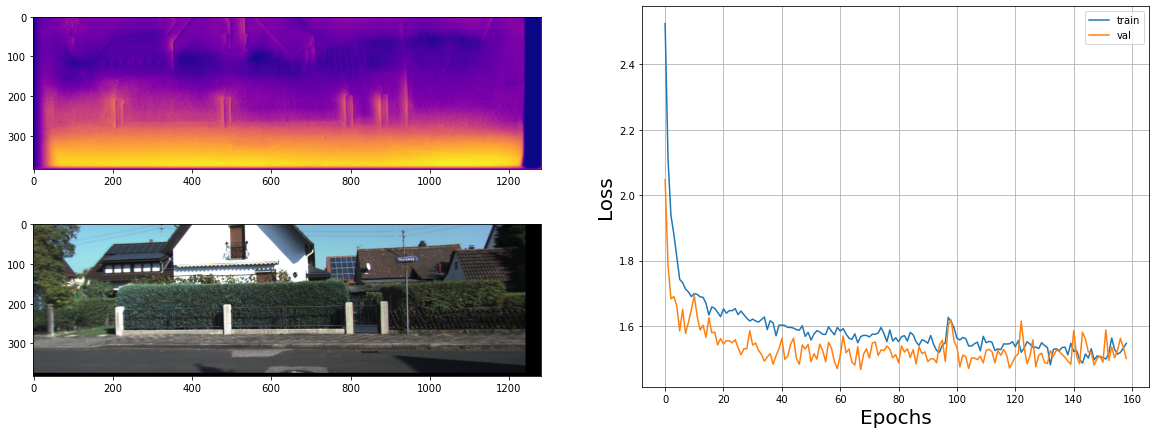

Epoch 159 of 200 took 270.784s



 54%|█████▍    | 293/545 [02:23<02:03,  2.04it/s]


KeyboardInterrupt: 

In [37]:
train_network(
    model, opt, criterion, 200
)

## Visualize some results from validation dataset

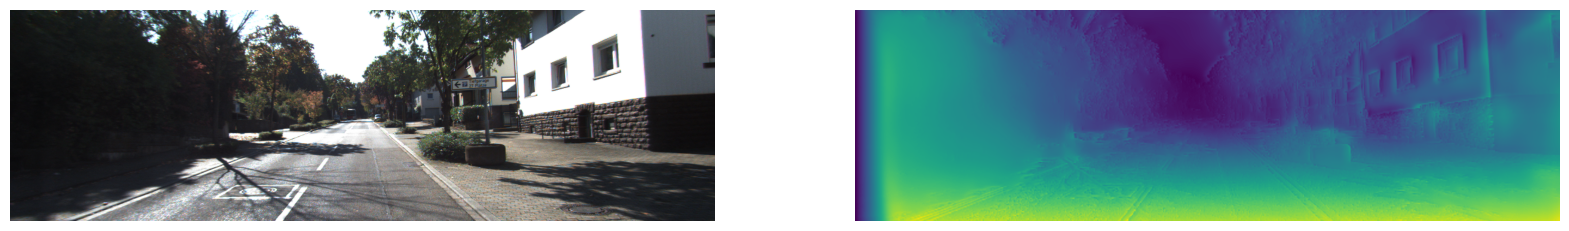

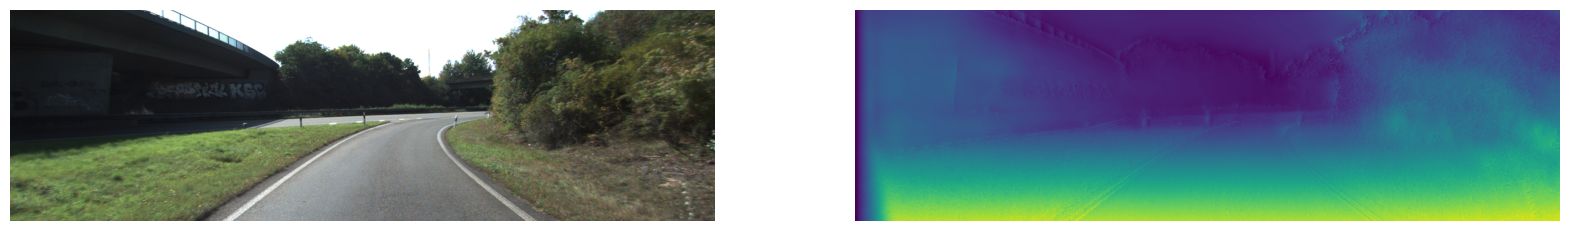

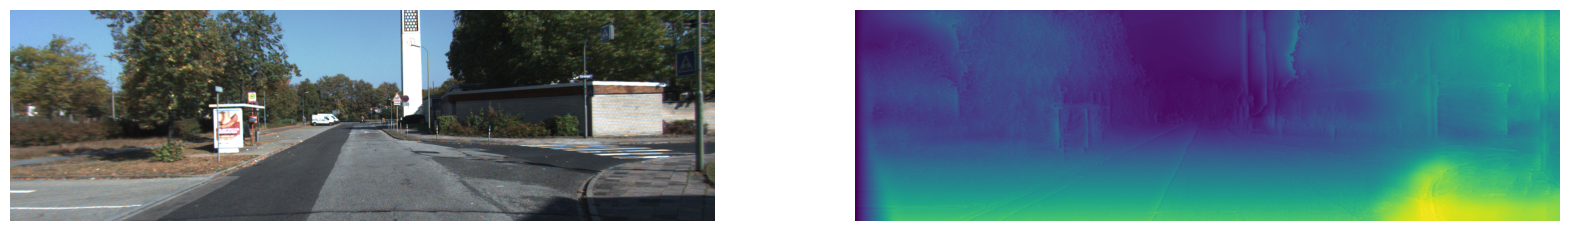

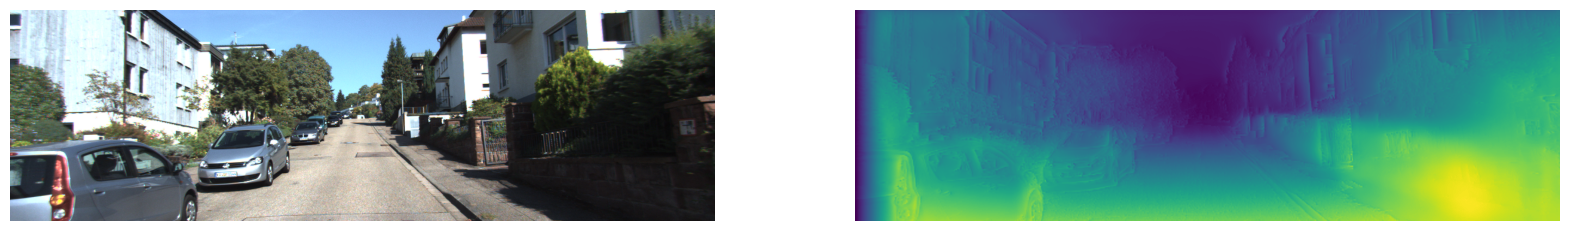

In [38]:
for i in [0, 5, 10, 11]:
    left_image, right_image = validation_dataset[i]
    
    with torch.no_grad():
        disp_maps = model(left_image[None].cuda())
        last_map = disp_maps[-1][0, 0].cpu().numpy()[:-30, :-100]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 7), dpi=100)
    axes[0].imshow(left_image.permute(1, 2, 0)[:-30, :-100])
    axes[1].imshow(last_map)
    axes[0].axis('off'); axes[1].axis('off');
    plt.show()

# Quality benchmark

![image](https://user-images.githubusercontent.com/20357655/144706889-2c6f31f1-7715-4ea1-b53a-025f8fe7e70c.png)